# Init

In [1]:
from __future__ import absolute_import, division, print_function

import logging
import sys

logging.basicConfig(
    stream=sys.stdout,
    level=logging.DEBUG,
    format='%(asctime)s %(name)s-%(levelname)s: %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S')
import os
import numpy as np
from modules import utils, feature_extraction as fe, postprocessing, visualization
from modules.data_generation import DataGenerator
import matplotlib.pyplot as plt

logger = logging.getLogger("dataGenNb")


## Generate data 

Data should be in an appropriate format and filtered before when we load it here. It does not have to be scaled. 

In [11]:
dg = DataGenerator(natoms=60, nclusters=6, nframes_per_cluster=500, noise_level=1e-3)
dg.generate_clusters()
feature_to_resids = dg.feature_to_resids()
data, labels = dg.generate_frames()
cluster_indices = labels.argmax(axis=1)
feature_to_resids = None
logger.info("Generated data of shape %s and %s clusters", data.shape, labels.shape[1])

2018-10-31 18:10:50 dataGenNb-INFO: Generated data of shape (3000, 1770) and 6 clusters


## Define the different methods to use

Every method is encapsulated in a so called FeatureExtractor class which all follow the same interface

In [12]:
n_iterations, n_splits = 10, 1
feature_extractors = [
    fe.MlpFeatureExtractor(data, labels, n_splits=n_splits, n_iterations=n_iterations),
    fe.ElmFeatureExtractor(data, labels, n_splits=n_splits, n_iterations=n_iterations),
    fe.KLFeatureExtractor(data, labels, n_splits=n_splits),
    fe.PCAFeatureExtractor(data, labels, n_splits=n_splits),
    fe.RandomForestFeatureExtractor(data, labels, n_splits=n_splits, n_iterations=n_iterations),
]
logger.info("Done. using %s feature extractors", len(feature_extractors))


2018-10-31 18:10:50 dataGenNb-INFO: Done. using 5 feature extractors


# Run the relevance analysis

In [13]:
results = []
for extractor in feature_extractors:
    logger.info("Computing relevance for extractors %s", extractor.name)
    feature_importance, std_feature_importance, errors = extractor.extract_features(filter_results=True)
    #logger.info("Get feature_importance and std of shapes %s, %s", feature_importance.shape, std_feature_importance.shape)
    results.append((extractor, feature_importance, std_feature_importance, errors))
logger.info("Done")


2018-10-31 18:10:50 dataGenNb-INFO: Computing relevance for extractors MLP
2018-10-31 18:10:50 Extracting feature-INFO: Using all data in training and validation sets
2018-10-31 18:10:51 Extracting feature-DEBUG: Iteration 1 of 10
2018-10-31 18:10:52 Extracting feature-DEBUG: Error: 0.0
2018-10-31 18:10:52 Extracting feature-DEBUG: Computing feature importance on all data.
2018-10-31 18:10:52 Extracting feature-DEBUG: Iteration 2 of 10
2018-10-31 18:10:53 Extracting feature-DEBUG: Error: 0.0
2018-10-31 18:10:53 Extracting feature-DEBUG: Computing feature importance on all data.
2018-10-31 18:10:54 Extracting feature-DEBUG: Iteration 3 of 10
2018-10-31 18:10:55 Extracting feature-DEBUG: Error: 0.0
2018-10-31 18:10:55 Extracting feature-DEBUG: Computing feature importance on all data.
2018-10-31 18:10:55 Extracting feature-DEBUG: Iteration 4 of 10
2018-10-31 18:10:56 Extracting feature-DEBUG: Error: 0.0
2018-10-31 18:10:56 Extracting feature-DEBUG: Computing feature importance on all dat

2018-10-31 18:11:48 RF featurizer-INFO: Training RF
2018-10-31 18:11:48 Extracting feature-DEBUG: Error: 0.0
2018-10-31 18:11:48 Extracting feature-DEBUG: Computing feature importance on all data.
2018-10-31 18:11:49 Extracting feature-DEBUG: Iteration 9 of 10
2018-10-31 18:11:49 RF featurizer-INFO: Training RF
2018-10-31 18:11:49 Extracting feature-DEBUG: Error: 0.0
2018-10-31 18:11:49 Extracting feature-DEBUG: Computing feature importance on all data.
2018-10-31 18:11:49 Extracting feature-DEBUG: Iteration 10 of 10
2018-10-31 18:11:50 RF featurizer-INFO: Training RF
2018-10-31 18:11:50 Extracting feature-DEBUG: Error: 0.0
2018-10-31 18:11:50 Extracting feature-DEBUG: Computing feature importance on all data.
2018-10-31 18:11:50 dataGenNb-INFO: Done


# Postprocess results to get average features

In [14]:
postprocessors = []
for (extractor, feature_importance, std_feature_importance, errors) in results:
    p = postprocessing.PostProcessor(extractor, feature_importance, std_feature_importance, errors, cluster_indices,
                                     working_dir=None, feature_to_resids=feature_to_resids)
    p.average()
    postprocessors.append(p)

logger.info("Done")


2018-10-31 18:11:51 postprocessing-DEBUG: Not possible to compute importance per cluster
2018-10-31 18:11:51 postprocessing-DEBUG: Not possible to compute importance per cluster
2018-10-31 18:11:51 dataGenNb-INFO: Done


# Visualize results

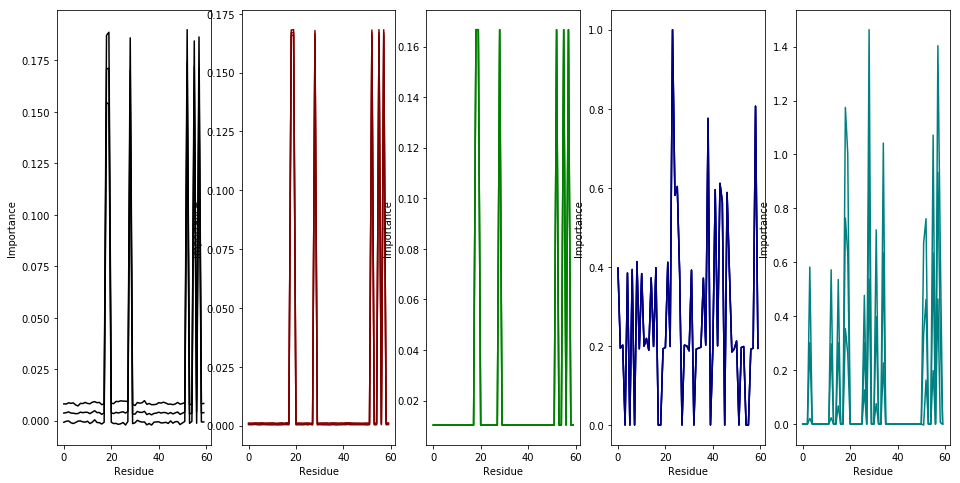

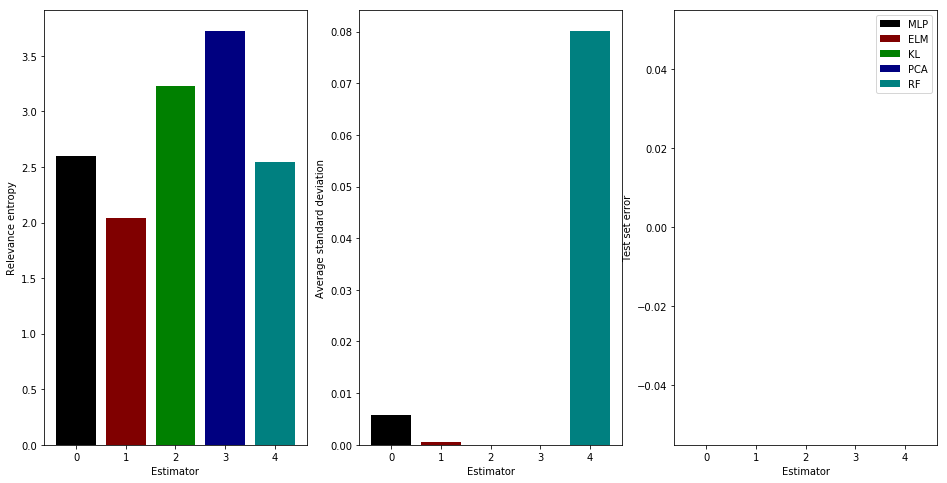

2018-10-31 18:12:14 dataGenNb-INFO: Actual atoms moved: [ 57.  18.  55.  28.  52.  19.]
2018-10-31 18:12:14 dataGenNb-INFO: Done


In [16]:
visualization.visualize(postprocessors)
logger.info("Actual atoms moved: %s", dg.moved_atoms)
logger.info("Done")